In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

loading data

In [3]:
df= pd.read_csv("diminos_data.csv")

Computing data from timestamps

In [13]:
df["order_placed_at"] = pd.to_datetime(df["order_placed_at"])
df["order_delivered_at"] = pd.to_datetime(df["order_delivered_at"])

In [15]:
df["delivery_time_mins"] = (df["order_delivered_at"] - df["order_placed_at"]).dt.total_seconds() / 60
#calculating delivery time in min

data cleaning

In [9]:
df = df.dropna(subset=["delivery_time_mins"])
df = df[df["delivery_time_mins"] > 0]

In [20]:
df.head()

,order_id,order_placed_at,order_delivered_at,delivery_time_mins
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132,17.140719
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241,15.598754
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385,15.104856
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056,16.176984


calculating SLA metrics

In [17]:
sla_limit = 31
p90 = np.percentile(df["delivery_time_mins"], 90)
p95 = np.percentile(df["delivery_time_mins"], 95)
p99 = np.percentile(df["delivery_time_mins"], 99)


In [19]:
mean_delivery = df["delivery_time_mins"].mean()
median_delivery = df["delivery_time_mins"].median()
total_orders = df.shape[0]

Identifying SLA breaches

In [23]:
df["sla_breach"] = df["delivery_time_mins"] > sla_limit

# breach percentage
breach_percentage = df["sla_breach"].mean() * 100
print(breach_percentage)

3.713333333333333


In [27]:
df["hour"] = df["order_placed_at"].dt.hour

hourly_avg_delivery = df.groupby("hour")["delivery_time_mins"].mean()
hourly_breach_rate = df.groupby("hour")["sla_breach"].mean() * 100
print(hourly_avg_delivery)
print(hourly_breach_rate)

hour
0     24.116781
1     20.836201
2     19.123197
3     19.846034
4     18.818769
5     17.727910
6     18.501060
7     18.368406
8     19.264601
9     33.320277
10    21.014310
11    25.908233
12    19.731810
13    18.403554
14    18.999574
15    17.619334
16    18.711819
17    30.352864
18    17.758926
19    18.253996
20    19.247353
21    18.263140
22    18.963806
23    18.544586
Name: delivery_time_mins, dtype: float64
hour
0     4.025765
1     5.573770
2     3.606557
3     3.497615
4     3.475513
5     2.496100
6     3.191489
7     3.577818
8     3.150912
9     2.996845
10    3.349282
11    5.190840
12    3.040000
13    4.180064
14    3.645008
15    2.657807
16    5.527638
17    4.700162
18    2.515723
19    3.301887
20    3.898305
21    3.773585
22    3.664122
23    4.160475
Name: sla_breach, dtype: float64


Detecting outliers using IQR

In [28]:
q1 = df["delivery_time_mins"].quantile(0.25)
q3 = df["delivery_time_mins"].quantile(0.75)
iqr = q3 - q1
print(iqr)

2.0048349083333363


In [30]:
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

outliers = df[
    (df["delivery_time_mins"] > upper_bound) |
    (df["delivery_time_mins"] < lower_bound)
]
print(outliers)


       order_id     order_placed_at         order_delivered_at  \
3       1523114 2023-03-01 00:07:47 2023-03-01 00:46:19.019399   
6       1523117 2023-03-01 00:11:09 2023-03-01 00:41:54.245295   
16      1523127 2023-03-01 00:37:10 2023-03-01 01:01:14.587491   
18      1523129 2023-03-01 00:43:31 2023-03-01 01:03:52.000746   
24      1523135 2023-03-01 01:11:53 2023-03-01 05:07:54.563978   
...         ...                 ...                        ...   
14949   1538060 2023-03-27 21:56:34 2023-03-27 22:21:20.206661   
14953   1538064 2023-03-27 22:04:53 2023-03-27 22:55:03.230465   
14970   1538081 2023-03-27 22:41:56 2023-03-27 23:09:33.139446   
14974   1538085 2023-03-27 22:56:11 2023-03-27 23:18:16.194531   
14982   1538093 2023-03-27 23:13:48 2023-03-27 23:37:13.388767   

       delivery_time_mins  sla_breach  hour  
3               38.533657        True     0  
6               30.754088       False     0  
16              24.076458       False     0  
18              20.3500

Visualizations

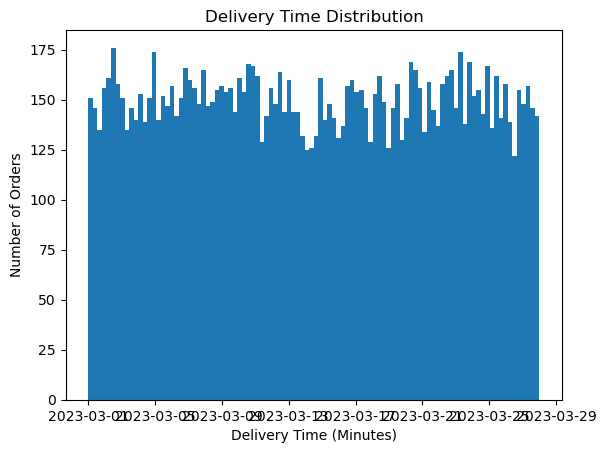

In [37]:

plt.hist(df["order_placed_at"], bins=100)
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery Time (Minutes)")
plt.ylabel("Number of Orders")
plt.show()

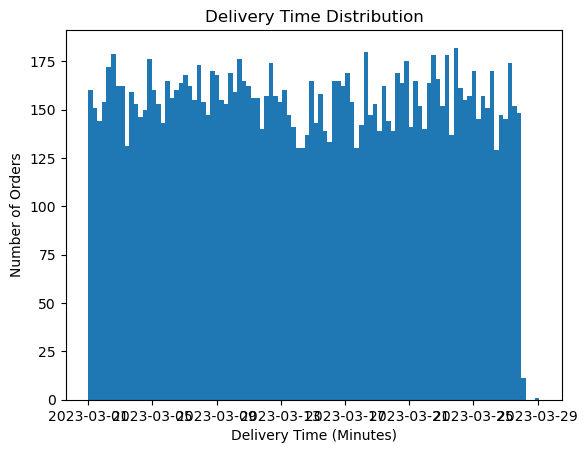

In [38]:
plt.hist(df["order_delivered_at"], bins=100)
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery Time (Minutes)")
plt.ylabel("Number of Orders")
plt.show()

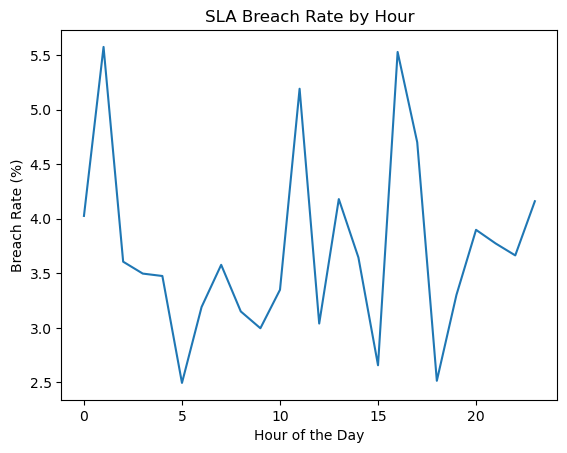

In [40]:
plt.figure()
plt.plot(hourly_breach_rate.index, hourly_breach_rate.values)
plt.title("SLA Breach Rate by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Breach Rate (%)")
plt.show()
#SLA breach rate across hours

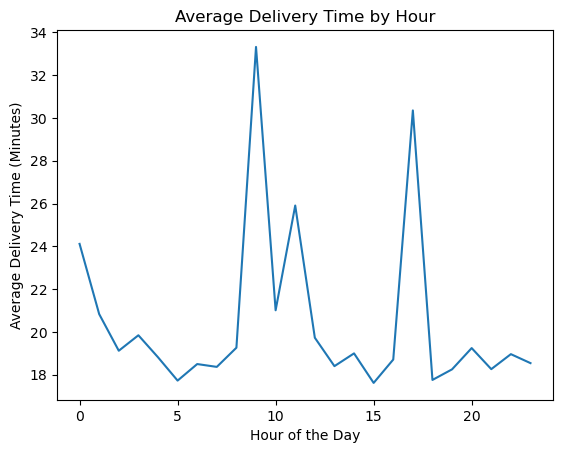

In [41]:
plt.figure()
plt.plot(hourly_avg_delivery.index, hourly_avg_delivery.values)
plt.title("Average Delivery Time by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Delivery Time (Minutes)")
plt.show()
#average delivery time in hours

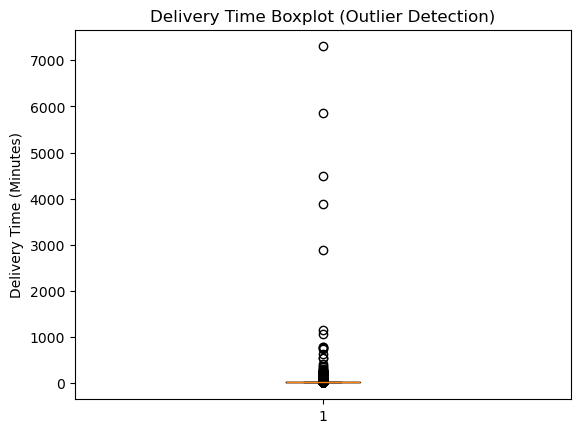

In [42]:
#boxplot
plt.figure()
plt.boxplot(df["delivery_time_mins"])
plt.title("Delivery Time Boxplot (Outlier Detection)")
plt.ylabel("Delivery Time (Minutes)")
plt.show()

Final performance analysis

In [52]:
print(f"Total Orders Evaluated: {total_orders}")
print(f"Average Delivery Time: {mean_delivery:.2f} minutes")
print(f"Median Delivery Time: {median_delivery:.2f} minutes")
print(f"90th Percentile Delivery Time: {p90:.2f} minutes")
print(f"95th Percentile Delivery Time: {p95:.2f} minutes")
print(f"99th Percentile Delivery Time: {p99:.2f} minutes")
print(f"SLA Breach Rate (>31 mins): {breach_percentage:.2f}%")
print(f"Franchise Metric Achieved: {p95 < 31}")

Total Orders Evaluated: 15000
Average Delivery Time: 20.50 minutes
Median Delivery Time: 15.80 minutes
90th Percentile Delivery Time: 21.16 minutes
95th Percentile Delivery Time: 27.26 minutes
99th Percentile Delivery Time: 65.06 minutes
SLA Breach Rate (>31 mins): 3.71%
Franchise Metric Achieved: True


Outlier analysis

In [53]:
print(f"Number of Outlier Orders: {outliers.shape[0]}")

if outliers.shape[0] > 0:
    print(f"Maximum Outlier Delivery Time: {outliers['delivery_time_mins'].max():.2f} minutes")

Number of Outlier Orders: 1734
Maximum Outlier Delivery Time: 7299.83 minutes
